In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
import requests
from bs4 import BeautifulSoup
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from scipy.stats import pearsonr, spearmanr
import kagglehub
from kagglehub import KaggleDatasetAdapter

In [ ]:
# Set the path to the file you'd like to load
file_path = "weekly_player_stats_offense.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "philiphyde1/nfl-stats-1999-2022",
  file_path,
)

import requests

# Years you want to pull
years = range(2016, 2024)  # Adjust as needed
all_adp = []

for y in years:
    url = f"https://fantasyfootballcalculator.com/api/v1/adp/ppr?teams=12&year={y}&position=all"
    try:
        r = requests.get(url)
        r.raise_for_status()
        data = r.json()

        # Each player entry is in data["players"]
        df_adp = pd.DataFrame(data["players"])
        df_adp["season"] = y
        all_adp.append(df_adp)
        print(f"{y} — {len(df_adp)} players loaded")
    except Exception as e:
        print(f"Error for {y}: {e}")

# Combine all into one DataFrame
adp_all = pd.concat(all_adp, ignore_index=True)

# Optional: clean player names
adp_all["name"] = adp_all["name"].str.strip()

# Preview
print(adp_all.head())

# Save to JSON if you want a file
adp_all.to_json("historical_adp_ppr.json", orient="records")

# --- Step 1: pick only the columns you want from ADP ---
# Example: name, position, team, average ADP, and season
# --- Step 1: pick only needed columns ---
adp_keep = adp_all[["name", "position", "team", "adp", "season"]].copy()

# --- Step 2: normalize player names for matching ---
adp_keep["player_name_merge"] = (
    adp_keep["name"]
    .str.strip()
    .str.replace(r"\s+Jr\.?$", "", regex=True)
    .str.replace(r"\s+Sr\.?$", "", regex=True)
)

# --- Step 3: average ADP per player-season ---
# If there are multiple ADP rows for the same player/season, this averages them
adp_all = (
    adp_keep
    .groupby(["season", "player_name_merge"], as_index=False)
    .agg({
        "adp": "first",          # average the ADP values
        }))

# --- Step 4: prep your main DF for merge ---
df["player_name_merge"] = (
    df["player_name"]
    .str.strip()
    .str.replace(r"\s+Jr\.?$", "", regex=True)
    .str.replace(r"\s+Sr\.?$", "", regex=True)
)

# --- Step 5: merge the averaged ADP into your stats ---
df= df.merge(adp_all, on=["season", "player_name_merge"], how="left")

# --- Step 6: check result ---
print(df[["player_name", "season", "adp", "position", "team"]].head())


/tmp/ipython-input-3391441060.py:5: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


2016 — 188 players loaded
2017 — 184 players loaded
2018 — 197 players loaded
2019 — 200 players loaded
2020 — 203 players loaded
2021 — 211 players loaded
2022 — 157 players loaded
2023 — 202 players loaded
   player_id               name position team  adp adp_formatted  \
0       1886      Antonio Brown       WR  PIT  1.2          1.01   
1       1796        Julio Jones       WR  ATL  2.8          1.03   
2       2113  Odell Beckham Jr.       WR  NYG  3.4          1.03   
3       2297      David Johnson       RB  ARI  3.4          1.03   
4       2280        Todd Gurley       RB  LAR  6.3          1.06   

   times_drafted  high  low  stdev  bye  season  
0            454     1    4    0.5    5    2016  
1            348     1    6    0.9    5    2016  
2            512     1   10    1.2   14    2016  
3            146     1    7    1.5    8    2016  
4            470     1   12    1.8    8    2016  
     player_name  season  adp position team
0  Charlie Batch    2012  NaN       QB 

In [ ]:
df=df[df["season"]>=2016]
df=df[df["season"]<=2022]
print(df["adp"])

15557    68.5
15558    68.5
15559    68.5
15560    68.5
15561    68.5
         ... 
48545     NaN
48546     NaN
48547     NaN
48548     NaN
48549     NaN
Name: adp, Length: 32993, dtype: float64


Train R²: 0.666
Test R²: 0.715
Cross-validated R² scores: [0.68304056 0.66144661 0.31714663 0.58010372 0.71914443]
Mean CV R²: 0.592


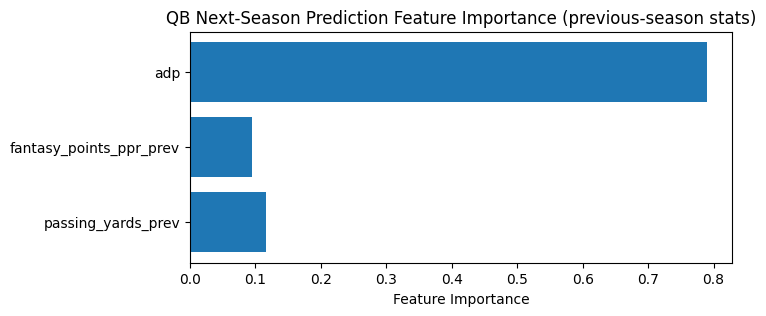


Top predictions (sorted by predicted value):
      player_id       player_name  season  target_season_actual  \
303  00-0036442        Joe Burrow    2022                434.59   
34   00-0023459     Aaron Rodgers    2021                316.59   
1    00-0019596         Tom Brady    2018                401.81   
243  00-0033873   Patrick Mahomes    2022                590.24   
299  00-0036355    Justin Herbert    2022                367.94   
70   00-0026498  Matthew Stafford    2022                106.16   
269  00-0034857        Josh Allen    2021                502.24   
5    00-0019596         Tom Brady    2022                283.00   
4    00-0019596         Tom Brady    2021                526.07   
48   00-0026143         Matt Ryan    2017                287.32   
50   00-0026143         Matt Ryan    2019                344.03   
105  00-0029263    Russell Wilson    2021                320.85   
280  00-0035228      Kyler Murray    2021                413.74   
6    00-0020531 

In [ ]:
# Predict next-season QB performance using previous-season stats
# Uses the same column names referenced in your clipboarded code.
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import numpy as np

# df is assumed to already exist and contain your raw play/week-level data
# Keep only QBs and required dtypes (adapted from your clipboard)
# Use 'position' from the merged dataframe
df = df[df['position'] == 'QB'].copy()

df['week'] = df['week'].astype(int)
df['season'] = df['season'].astype(int)
# ensure fantasy column is float if present
# Use the appropriate fantasy points column from the merged dataframe (likely 'fantasy_points_ppr' or 'season_average_fantasy_points_ppr')
# Let's assume 'fantasy_points_ppr' is the one from the original stats data
if 'fantasy_points_ppr' in df.columns:
    df['fantasy_points_ppr'] = df['fantasy_points_ppr'].astype(float)
    fantasy_points_col = 'fantasy_points_ppr'
elif 'season_average_fantasy_points_ppr' in df.columns:
     df['season_average_fantasy_points_ppr'] = df['season_average_fantasy_points_ppr'].astype(float)
     fantasy_points_col = 'season_average_fantasy_points_ppr'
else:
    raise KeyError("No suitable fantasy points column found in the dataframe.")


# 1) Aggregate season-level numeric stats per player-season (season totals / means as appropriate)
numeric_cols = df.select_dtypes(include='number').columns.tolist()
# keep player_id, player_name, season for grouping
group_cols = ['player_id', 'season']
# Remove 'season' and 'adp' from the columns to be aggregated with sum
agg_cols = {c: 'sum' for c in numeric_cols if c not in group_cols}

# Add adp with 'first' aggregation

season_agg = df.groupby(group_cols).agg(
    agg_cols
).reset_index() # season is now correctly a column after reset_index


# Optionally also keep player_name (first occurrence)
if 'player_name' in df.columns:
    names = df.groupby(group_cols)['player_name'].first().reset_index()
    # Merge on group_cols after reset_index
    season_agg = season_agg.merge(names[['player_id', 'season', 'player_name']], on=['player_id', 'season'], how='left')


# 2) Build previous-season features -> next-season target
# shift season by +1 to align previous season stats with the following season target
prev = season_agg.copy()
prev['season'] = prev['season'] + 1
# suffix previous-season feature names with _prev so they are explicit
prev = prev.add_suffix('_prev')
# fix column names for join: player_id_prev and season_prev exist; we will join on those matching current season
# prepare current-season frame (target season)
curr = season_agg.copy()
# Merge prev (previous-season stats) onto curr (current season) using player_id and season
merged_prev_next = curr.merge(
    prev,
    left_on=['player_id', 'season'],
    right_on=['player_id_prev', 'season_prev'],
    how='inner'  # inner join ensures we only keep seasons where previous season data exists
)

# 3) Choose features and target using same column names where possible
# Example feature columns (from your clipboard): passing_yards, fantasy_points_ppr, qb_dropback, team_offense_snaps, first_down_pass, adp
# We expect these to exist as numeric season aggregates in season_agg; adjust if your column names differ.
# Use the appropriate column names from the merged dataframe


# Create list of features from the previous-season suffixed columns
features = [    'passing_yards_prev', 'fantasy_points_ppr_prev', 'adp'
]

# Define target as the current season's season_average_fantasy_points_ppr if available,
# otherwise fall back to the aggregated fantasy points column.
# Use the appropriate target column from the merged dataframe
if 'season_average_fantasy_points_ppr' in merged_prev_next.columns:
    target = 'season_average_fantasy_points_ppr'
elif fantasy_points_col in merged_prev_next.columns:
    target = fantasy_points_col
else:
    raise KeyError("No suitable target column found in the merged dataframe.")


# Drop rows with NaNs in features/target
model_df = merged_prev_next.dropna(subset=features + [target]).copy()

# Basic train/test split
X = model_df[features]
y = model_df[target]
identifiers = model_df[['player_id', 'season', 'player_name']] if 'player_name' in model_df.columns else model_df[['player_id', 'season']]

X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, identifiers.index, test_size=0.3, random_state=42
)

# 4) Model (RandomForestRegressor with overfitting control like your clipboard)
model = RandomForestRegressor(
    n_estimators=550,
    min_samples_split=7,
    min_samples_leaf=12,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)

# Evaluate
train_r2 = model.score(X_train, y_train)
test_r2 = model.score(X_test, y_test)
print(f"Train R²: {train_r2:.3f}")
print(f"Test R²: {test_r2:.3f}")

# Cross-validation on full dataset
cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2', n_jobs=-1)
print(f"Cross-validated R² scores: {cv_scores}")
print(f"Mean CV R²: {cv_scores.mean():.3f}")

# Feature importance plot
importances = model.feature_importances_
plt.figure(figsize=(7, max(3, len(features) * 0.5)))
plt.barh(features, importances)
plt.xlabel("Feature Importance")
plt.title("QB Next-Season Prediction Feature Importance (previous-season stats)")
plt.show()

# 5) Generate predictions and results table (predicting current season using previous-season stats)
preds = model.predict(X)
results = pd.DataFrame({
    'player_id': identifiers.loc[X.index, 'player_id'],
    'player_name': identifiers.loc[X.index, 'player_name'] if 'player_name' in identifiers.columns else np.nan,
    'season': identifiers.loc[X.index, 'season'],
    'target_season_actual': y,
    'predicted_from_prev_season': preds,
    'error': y - preds
}, index=X.index)

# show top results by predicted value
print("\nTop predictions (sorted by predicted value):")
print(results.sort_values('predicted_from_prev_season', ascending=False).head(15))

# Optional: export results
# results.to_csv("qb_next_season_predictions_from_prev.csv", index=False)

In [ ]:
# Rank players by ADP (lower ADP = better rank)
results["adp_rank"] = results.groupby("season")["adp"].rank(method="min", ascending=True)

# Rank players by predicted performance (higher predicted points = better rank)
results["predicted_rank"] = results.groupby("season")["predicted_from_prev_season"] \
                                   .rank(method="min", ascending=False)

# Optional: difference between how your model ranks them and how the market ranked them
results["rank_diff"] = results["predicted_rank"] - results["adp_rank"]

# Now you can sort by rank_diff to find biggest sleepers / overvalued players
print(results.sort_values(["season", "rank_diff"]).head(15))


KeyError: 'Column not found: adp'

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

# Assume df is already loaded and filtered for QBs from 2016-2022 (as per cell T9WZ8koDR4Yp)
# The variable 'df' in this cell should be the filtered QB dataframe.
# To ensure this, let's explicitly filter 'df' again for clarity, though it might be redundant if T9WZ8koDR4Yp ran just before.
# If running this cell independently, you might need to re-run cell T9WZ8koDR4Yp first to get the correct 'df'.

# Let's assume df is the QB dataframe from 2016-2022
# df = df[(df['season'] >= 2016) & (df['season'] <= 2022)].copy() # This should have been done upstream
# df = df[df['position'] == 'QB'].copy() # This should have been done upstream

# 1) Aggregate season-level numeric stats per player-season
# Group by player_id and season, and sum numeric columns.
# 'season' is included in the groupby key, so it will become part of the index.
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
group_cols = ['player_id', 'season']

# Create aggregation dictionary, excluding the grouping columns from the sum list
agg_dict = {col: 'sum' for col in numeric_cols if col not in group_cols}

season_agg = df.groupby(group_cols).agg(agg_dict).reset_index()

# Optionally also keep player_name (first occurrence)
if 'player_name' in df.columns:
    names = df.groupby(group_cols)['player_name'].first().reset_index()
    season_agg = season_agg.merge(names[['player_id', 'season', 'player_name']], on=['player_id', 'season'], how='left')


# 2) Build previous-season features -> next-season target
# Prepare previous-season feature: use previous season's fantasy points
# Determine which fantasy column to use as the feature and target
feat_col = None
target_col = None

# First, let's make sure the necessary columns exist in season_agg after aggregation
# Note: 'fantasy_points_ppr' or 'season_average_fantasy_points_ppr'
# should ideally come from the aggregation or be merged subsequently.
# Based on cell T9WZ8koDR4Yp, 'fantasy_points_ppr' seems to be an aggregated column.
# 'season_average_fantasy_points_ppr' might also be available or calculated.

# Let's check which columns are available in season_agg for fantasy points
available_fantasy_cols = [col for col in ['overall', 'season_average_fantasy_points_ppr'] if col in season_agg.columns]

if not available_fantasy_cols:
    raise KeyError("Missing required fantasy columns ('fantasy_points_ppr' or 'season_average_fantasy_points_ppr') in aggregated data.")

# Use the first available fantasy column for both feature and target for this baseline model
# If season_average_fantasy_points_ppr exists, use it for the target. Otherwise use fantasy_points_ppr
target_col = 'season_average_fantasy_points_ppr'
    # Use fantasy_points_ppr for the feature if available, otherwise use the target_col
feat_col = 'adp'


prev = season_agg.copy()
prev['season'] = prev['season'] + 1
# Rename the feature column with _prev suffix
if feat_col in prev.columns:
    prev = prev[['player_id', 'season', feat_col]].rename(columns={feat_col: feat_col + '_prev'})
else:
     raise KeyError(f"Feature column '{feat_col}' not found in previous season data.")


curr = season_agg.copy()
# Merge prev (previous-season stats) onto curr (current season) using player_id and season
merged_baseline = curr.merge(prev, on=['player_id', 'season'], how='inner')

# Keep only rows without NaNs in feature/target
merged_baseline = merged_baseline.dropna(subset=[feat_col + '_prev', target_col]).copy()

# Baseline feature matrix and target
X = merged_baseline[[feat_col]].values  # single-feature baseline
y = merged_baseline[target_col].values

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Model: simple linear regression baseline
model = RandomForestRegressor(
    n_estimators=550,
    min_samples_split=7,
    min_samples_leaf=12,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)

# Predictions and evaluation
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

print(f"Train R²: {r2_score(y_train, y_pred_train):.3f}")
print(f"Test R²: {r2_score(y_test, y_pred_test):.3f}")
# Need to import mean_absolute_error if not already imported
# from sklearn.metrics import mean_absolute_error
print(f"Test MAE: {mean_absolute_error(y_test, y_pred_test):.3f}")

# Cross-validated R²
cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
print(f"Cross-validated R² scores: {cv_scores}")
print(f"Mean CV R²: {cv_scores.mean():.3f}")

# Results dataframe with player info and errors
# Ensure columns used exist in merged_baseline
results = pd.DataFrame({
    'player_id': merged_baseline['player_id'],
    'player_name': merged_baseline['player_name'] if 'player_name' in merged_baseline.columns else np.nan,
    'season': merged_baseline['season'],
    'adp': merged_baseline[feat_col],
    'actual_target_season': merged_baseline[target_col],
    'predicted_target_season': model.predict(merged_baseline[[feat_col + '_prev']].values)
})

results['error'] = results['actual_target_season'] - results['predicted_target_season']

# Show top 10 by prev_season_fantasy
print("\nBaseline predictions (top by previous-season fantasy):")
print(results.sort_values("adp", ascending=False).head(10))


In [ ]:
print(len(results['predicted_target_season'].unique()))
print(len(results['actual_target_season'].unique()))

In [ ]:
print(df.columns)